# Modeling Churn: Random Forest Model

**Import Packages**

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
import optuna
from sklearn.model_selection import cross_val_score
import pickle
import imageio.v3 as iio

## Function Block

**Create Dummies**

In [2]:
def dummies(df, dummy_columns):
    """
    Creates dummies for categorical columns in the dataframe
    
    Parameters:
    - df: DataFrame containing the data
    - dummy_columns: List of categorical columns to create dummies for

    Return:
    - The modified dataframe.
    """
    df = df.copy()

    for item in dummy_columns:

        # Store dummies as integers
        dummies = pd.get_dummies(df[item], prefix = item).astype(int)

        # Concats the original dataframe with the dummies
        df = pd.concat([df, dummies], axis=1)

        # Drops the original column
        df.drop(item, axis=1, inplace=True)
    
    return df

**Prepare Data for Machine Learning**

In [3]:
def prepare_data(df, drop_columns, target_column, test_size = 0.2, random_state = 0):
    """
    Splits the dataset into train and test sets and scales the features with the Standard Scaler.
    
    Parameters:
    - df: The DataFrame containing features and target.
    - drop_columns: List of columns to drop (e.g., id columns).
    - target_column
    - test_size: Proportion of data to use as test set.
    - random_state: Random seed for reproducibility.
    
    Returns:
    - X_train, X_test, y_train, y_test: Scaled train-test split data.
    - scaler: The fitted StandardScaler object.
    """

    # Define features of the model by dropping any id related columns and the target column
    features = df.drop(columns = drop_columns + [target_column])

    # Define the target column
    target = df[target_column]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_size, random_state = random_state)

    # Create an instance of the standard scaler
    scaler = StandardScaler()

    # Save the scaler to a file using pickle
    with open("../scalers/standard_scaler.pkl", "wb") as file:
        pickle.dump(scaler, file)
        
    # Fit the scaler to the train data
    scaler.fit(X_train)

    # Transform the train and test data with the scaler instance
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return (pd.DataFrame(X_train_scaled, columns = X_train.columns), 
            pd.DataFrame(X_test_scaled, columns = X_test.columns),
            y_train, y_test, scaler)

**Train the Random Forest Model**

In [4]:
def train_random_forest(X_train, y_train, n_estimators = 200, max_depth = 20):
    """
    Trains a Random Forest classifier.
    
    Parameters:
    - X_train: Training features.
    - y_train: Training target.
    - n_estimators: Number of trees in the forest.
    - max_depth: Maximum depth of the trees.
    
    Returns:
    - Trained RandomForestClassifier model.
    """
    # Creates an instance of the random forest classifier
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 0)

    # Trains the classifier with the train data
    model.fit(X_train, y_train)

    return model

**Model Performance Evaluation**

In [5]:
def evaluate_model(model, X_test, y_test):
    
    """
    Evaluates the model on the test set.
    
    Parameters:
    - model: Trained model.
    - X_test: Test features.
    - y_test: Test target.
    
    Returns:
    - A dictionary containing accuracy, precision, and recall scores.
    """

    y_pred = model.predict(X_test)
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='binary'),
        "Recall": recall_score(y_test, y_pred, average='binary')}
    
    return scores

**Train the Tuned Random Forest Model**

In [ ]:
def train_random_forest_tuned(X_train, y_train, n_trials = 50, cv = 5):
    
    """
    Tunes hyperparameters and trains the RandomForest model with the best configuration.

    Parameters:
    - X_train: Scaled training features.
    - y_train: Training target.
    - n_trials: Number of trials for hyperparameter tuning (default: 50).
    - cv: Number of cross-validation folds for evaluation (default: 5).

    Returns:
    - tuned_model: The trained RandomForest model with the best hyperparameters.
    """
    
    # 50 trials balance exploration and exploitation of the hyperparameter space.


    # 5 folds provide a reliable performance estimate and a reasonable computational cost.
    # More folds would leed to lower biases but increase computational cost quickly, less folds would lead to higher variance.

    def objective(trial):

        """
        Defines the objective function for hyperparameter optimization using Optuna.

        Parameters:
        - trial: An Optuna trial object used to suggest hyperparameter values.

        Returns:
        - The average recall score for the given hyperparameter combination.
        """
    
        # Suggests values for key hyperparameters of the Random Forest model.
        n_estimators = trial.suggest_int('n_estimators', 200, 300)
        max_depth = trial.suggest_int('max_depth', 20, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 5, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)

        # Evaluates the model using 5-fold cross-validation with recall as the scoring metric.
        model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth,
                                    min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,
                                    class_weight = 'balanced', # 10% churn definetely requires to balance the datasets
                                    random_state = 0)

        # Define recall scorer to treat the low recall
        recall_scorer = make_scorer(recall_score)

        # Evaluate using cross validation and parallel computation (n_jobs = -1)
        # Compute the mean of all recall scores finally
        score = cross_val_score(model, X_train, y_train, cv = cv, scoring = recall_scorer, n_jobs = - 1).mean()

        return score

    # Create an Optuna study and optimize the objective
    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = n_trials)

    # Extract the best parameters and model
    tuned_params = study.best_params
    print('The best parameters are:', tuned_params)
    
    tuned_model = RandomForestClassifier(
        n_estimators = tuned_params['n_estimators'], max_depth = tuned_params['max_depth'],
        min_samples_split = tuned_params['min_samples_split'], min_samples_leaf = tuned_params['min_samples_leaf'],
        class_weight = 'balanced', random_state=0)
    
    # Trains the model with the best hyperparameters
    tuned_model.fit(X_train, y_train)

    return tuned_model

# Workflow

In [7]:
# Load clean dataframe with engineered features
df = pd.read_csv('../data/raw/describe_price.csv')

# Remove months_active since it stores almost the same information as tenure_years
df.drop(columns = ['months_active'])
df.head()

,id,channel_sales,tenure_years,months_active,months_to_end,months_since_modified,months_since_renewed,avg_yearly_consumption,avg_monthly_consumption,avg_yearly_gas_consumption,...,std_price_off_peak_var,std_price_peak_var,std_price_mid_peak_var,range_price_peak_var,range_price_off_peak_var,range_price_mid_peak_var,range_price_peak_fix,range_price_off_peak_fix,range_price_mid_peak_fix,churn
0,987e2767a9812e900db0041930d126cb,0,3,30,5,2,6,7502,0,0,...,0.002,0.000,0.000,0.000,0.004,0.000,0.000,0.178,0.000,0
1,5d5431b8305bb08ab589db356d2b54ef,0,3,30,9,24,2,27382,340,0,...,0.002,0.000,0.000,0.000,0.004,0.000,0.000,0.178,0.000,0
2,17e84c1bc19211777dfbb1cca8af94fc,0,3,30,9,26,2,463646,40551,0,...,0.004,0.002,0.001,0.004,0.008,0.003,0.098,0.163,0.065,0
3,dd490452dadf88529466072605d7ee82,0,3,30,5,2,6,3315,0,0,...,0.002,0.000,0.000,0.000,0.004,0.000,0.000,0.178,0.000,0
4,a33668b7d0d8d86f38ad983c0cad6095,0,3,30,12,11,0,63969,63969,7488,...,0.014,0.056,0.049,0.152,0.044,0.104,24.937,4.697,16.792,0


In [8]:
# Create dummies for channel sales
df = dummies(df, ['channel_sales'])
df.head()

,id,tenure_years,months_active,months_to_end,months_since_modified,months_since_renewed,avg_yearly_consumption,avg_monthly_consumption,avg_yearly_gas_consumption,avg_yearly_forecast_consumption,...,range_price_mid_peak_var,range_price_peak_fix,range_price_off_peak_fix,range_price_mid_peak_fix,churn,channel_sales_0,channel_sales_1,channel_sales_2,channel_sales_3,channel_sales_4
0,987e2767a9812e900db0041930d126cb,3,30,5,2,6,7502,0,0,276,...,0.000,0.000,0.178,0.000,0,1,0,0,0,0
1,5d5431b8305bb08ab589db356d2b54ef,3,30,9,24,2,27382,340,0,4061,...,0.000,0.000,0.178,0.000,0,1,0,0,0,0
2,17e84c1bc19211777dfbb1cca8af94fc,3,30,9,26,2,463646,40551,0,2859,...,0.003,0.098,0.163,0.065,0,1,0,0,0,0
3,dd490452dadf88529466072605d7ee82,3,30,5,2,6,3315,0,0,496,...,0.000,0.000,0.178,0.000,0,1,0,0,0,0
4,a33668b7d0d8d86f38ad983c0cad6095,3,30,12,11,0,63969,63969,7488,9683,...,0.104,24.937,4.697,16.792,0,1,0,0,0,0


## Random Forest Model

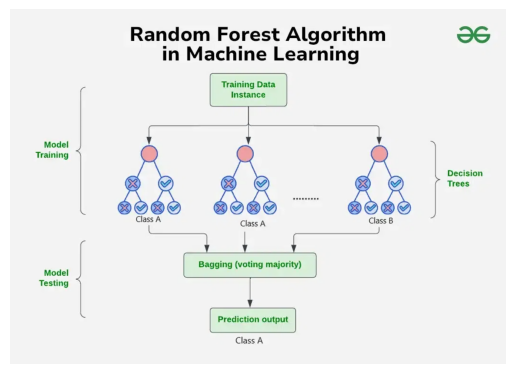

In [24]:
image = iio.imread('../data/Random-Forest-Algorithm.png')
plt.imshow(image)
plt.axis('off');

**What is a Random Forest model?**

The Random Forest is an ensemble machine learning algorithm used for classification and regression tasks. It builds multiple decision trees during training and combines their outputs to make more accurate and robust predictions.

- Bagging: Trains each tree on a random subset of the data to reduce overfitting.
- Feature Randomness: Considers random subsets of features at each split, thereby lowering the correlation between trees.
- Ensemble Learning: Aggregates predictions (majority vote) from multiple trees to improve accuracy and stability.

**Why do I use a Random Forest model?**

Challenges with KNN:

- Requires to scale all features equally, which may not capture feature importance effectively.
- Computationally extensive for large datasets, as it requires to store the entire dataset and perform calculations for each prediction.
- KNN struggles with highly nonlinear relationships and imbalanced datasets.

Challenges with Logistic Regression:

- Assumes a linear relationship between features and the log-odds of the target, which may oversimplify the churn behavior. 
- Needs transformation or interaction terms to capture nonlinear patterns (Feature Engineering).
- Struggles with imbalanced datasets unless oversampling/undersampling techniques are applied.

Motivation to use a Decision-Tree Model:
- Decision trees model complex, nonlinear relationships between features and target without requiring extensive tuning or scaling.
- Provide information on which features are most influential in predicting churn, which may be important for business insights.
- Decision-tree-based models can handle missing data and outliers better than regression or KNN.
- The class_weight parameter ensures that the minority class is given appropriate importance.

Motivation to use a Random Foerst Model:
- Random Forest scales efficiently with large datasets and high-dimensional data due to its efficient training process.
- Random Forest reduces overfitting compared to a single decision tree by averaging predictions across multiple trees.


In [ ]:
# Prepare the data
X_train, X_test, y_train, y_test, scaler = prepare_data(df, drop_columns = ['id'], target_column= "churn")

# Train the model with the train data
model = train_random_forest(X_train, y_train, n_estimators = 100, max_depth = 20)
# 100 estimators
# 20 tree depth

# Evaluate the model with the test data
scores = evaluate_model(model, X_test, y_test)
print(scores)

{'Accuracy': 0.9064427690198766, 'Precision': 0.8888888888888888, 'Recall': 0.05574912891986063}


**Why do I use the StandardScaler?**
- The StandardScaler is less sensitive to outliers and scales each column to a mean of 0 and a standard deviation of 1. 
- All features are treated on the same scale in terms of the standard deviation from the mean, which can be advantageous for consistent model training and feature importance interpretation. 
- The MinMaxScaler is useful for distance-based algorithms like KNN, but can distort scaling in the presence of outliers. 
- Without checking the metrics of all columns (minimum, maximum, normality) the StandardScaler is the safer options.

## Hyperparameter Tuning

**Parameters**

*n_estimators*
- Number of trees in the forest.
- Default: 100.
- The number of trees in the forest directly impacts the model's performance and training time. Too few trees might underfit the data, while too many trees can lead to unnecessary computation.
- Controls the overall stability and accuracy of the model.

*max_depth*
- Maximum depth of each decision tree.
- Default: None (nodes are expanded until all leaves are pure or contain less than min_samples_split samples).
- The depth of the trees determines how much the model learns from the data. Deeper trees can capture more complex patterns but are prone to overfitting.
- Critical for balancing model complexity and generalization.

*min_samples_split*
- Minimum number of samples required to split an internal node.
- Default: 2.
- min_samples_split: This parameter controls when a node can be split. Larger values prevent overly deep trees and reduce overfitting.
- Helps create more generalizable models, particularly for datasets prone to overfitting.

*min_samples_leaf*
- Minimum number of samples required to be at a leaf node. 
- Default: 1.
- Ensures that leaf nodes have a minimum number of samples. This prevents the model from being overly sensitive to individual data points.
- Helps smooth decision boundaries and avoids creating overly complex trees (reduce overfitting).

*max_features*
- Number of features to consider when looking for the best split.
- Options: None (all features) sqrt (of the total number of features), log2 (of the total number of features), integer
- Controls randomness in splits. Smaller values increase randomness, thereby improving generalization.
- For classification, sqrt works well (default). For regression, use None or log2.

*class_weight*
- Weights associated with classes to address imbalanced datasets.
- Options: None (no weights), balanced (adjusts weights inversely proportional to class frequencies), or manually define weights for each class.
- Helps the model focus on minority classes, thereby improving recall for underrepresented categories.
- Default: None.

These four parameters are among the most influential for controlling the **bias-variance tradeoff** in Random Forests.

**Why do I use Bayesian search?**

- Grid search is simple since it covers the whole parameter space but it is computationally exhaustive. Since this parameter space is continuous, a very fine grid is needed.
- Random search is not systematic since it could miss optimal regions if random sampling does not hit them, and also inefficient because it randomly evaluates combinations without learning from past evaluations.
- Bayesian search uses past evaluations to estimate which hyperparameter regions are promising and explores them more. Meanwhile it balances exploration (trying new regions) and exploitation (focusing on areas with good results). It works well with continuous, large, or high-dimensional spaces as in this case.

**What is cross validation?**
1. The entire dataset is divided into a training set and a test set (e.g., 80% train, 20% test).
2. The test set is set aside for final evaluation and is not involved in the cross-validation or training.
3. The training set is further split into multiple folds (e.g., 5 folds).
4. For each fold: one subset is used for validation, and the remaining subsets are used for training. This process is repeated until every fold has been used once as the validation set.

**Why do I optimize for accuracy?**

In [ ]:
# Train the tuned model (inherent parameter optimization)
tuned_model = train_random_forest_tuned(X_train, y_train, n_trials = 50) 

# Evaluate the tuned model
tuned_scores = evaluate_model(tuned_model, X_test, y_test)
print(tuned_scores)

[I 2024-12-17 10:04:56,817] A new study created in memory with name: no-name-b5467afe-d6ac-453d-8bdc-ad2d9d50f923
[I 2024-12-17 10:05:31,923] Trial 0 finished with value: 0.08303769833534755 and parameters: {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.08303769833534755.
[I 2024-12-17 10:05:48,287] Trial 1 finished with value: 0.08922069315036452 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.08922069315036452.
[I 2024-12-17 10:06:07,026] Trial 2 finished with value: 0.067135784179954 and parameters: {'n_estimators': 223, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.08922069315036452.
[I 2024-12-17 10:06:21,410] Trial 3 finished with value: 0.09539589099840162 and parameters: {'n_estimators': 214, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 3 with 

The best parameters are: {'n_estimators': 259, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 3}


# Feature Importances

In [23]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

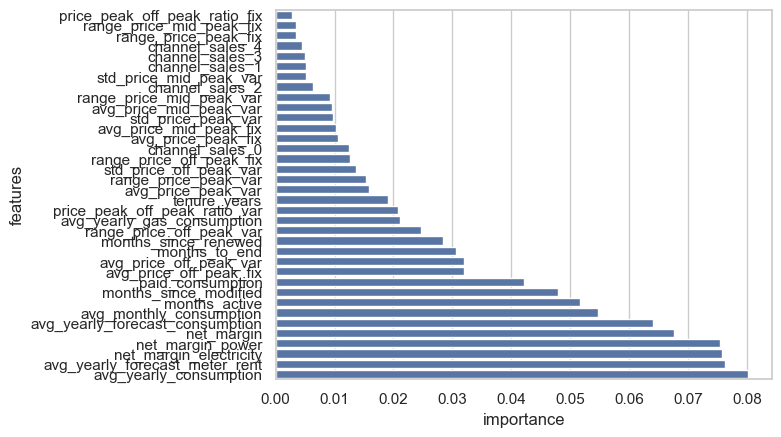

In [24]:
sns.set(style="whitegrid")
sns.barplot(x='importance', y='features', data=feature_importances);